In [1]:
!git clone https://github.com/uakarsh/latr.git

Cloning into 'latr'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 260 (delta 78), reused 67 (delta 64), pack-reused 164
Receiving objects: 100% (260/260), 3.71 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [2]:
!pip -qqq install -r ./latr/requirements.txt

In [3]:
!sudo apt install -qqq tesseract-ocr

In [4]:
## Default Library import

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import json
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import json

## For the purpose of displaying the progress of map function
tqdm.pandas()

import pytesseract
from PIL import Image, ImageDraw
from transformers import AutoTokenizer
from torchvision.transforms import ToPILImage

## Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
## Setting the hyperparameters as well as primary configurations

PAD_TOKEN_BOX = [0, 0, 0, 0]
QUESTION_BOX = [0, 0, 1000, 1000]
EOS_BOX = [0, 0, 0, 0]

max_seq_len = 512
batch_size = 2
target_size = (512,384)
t5_model = "t5-base"

tokenizer = AutoTokenizer.from_pretrained(t5_model, model_max_length = max_seq_len, use_fast = True)

In [6]:
base_path = '/kaggle/input/new-textvqa-dataset-mine'
ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_train.json')
train_json_path = os.path.join(base_path, 'TextVQA_0.5.1_train.json')

val_ocr_json_path = os.path.join(base_path, 'TextVQA_Rosetta_OCR_v0.2_val.json')
val_json_path = os.path.join(base_path, 'TextVQA_0.5.1_val.json')

In [7]:
with open(ocr_json_path) as f:
    train_ocr_json = json.load(f)['data']
with open(train_json_path) as f:
    train_json = json.load(f)['data']
    
## Validation
with open(val_ocr_json_path) as f:
    val_ocr_json = json.load(f)['data']
with open(val_json_path) as f:
    val_json = json.load(f)['data']

In [8]:
## Useful for the key-value extraction

train_json_df = pd.DataFrame(train_json)
train_ocr_json_df = pd.DataFrame(train_ocr_json)

val_json_df = pd.DataFrame(val_json)
val_ocr_json_df = pd.DataFrame(val_ocr_json)

In [9]:
train_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens',# 'path_exists'
                              ], axis = 1, inplace = True)

val_json_df.drop(columns = ['flickr_original_url', 'flickr_300k_url','image_classes', 'question_tokens',# 'path_exists'
                              ], axis = 1, inplace = True)
## Deleting the json

del train_json
del train_ocr_json
del val_json
del val_ocr_json

In [10]:
def normalize_box(box, width, height, size=1000):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size * (box[0] / width)),
        int(size * (box[1] / height)),
        int(size * (box[2] / width)),
        int(size * (box[3] / height)),
    ]

In [11]:
## Reference: https://github.com/uakarsh/TiLT-Implementation/blob/main/src/dataset.py

def get_tokens_with_boxes(unnormalized_word_boxes, list_of_words, tokenizer, pad_token_box = [0, 0, 0, 0], max_seq_len = -1):
    ## 2. Performing the semantic pre-processing
    encoding = tokenizer(list_of_words, is_split_into_words = True, add_special_tokens = False)

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    ## Note that, there is no need for bboxes, since the model does not use bbox as feature, so no pre-processing of that
    bbox_according_to_tokenizer = [unnormalized_word_boxes[i] for i in encoding.word_ids()]

    # Truncation of token_boxes + token_labels
    special_tokens_count = 1
    if max_seq_len != -1 and len(input_ids) > max_seq_len - special_tokens_count:
        bbox_according_to_tokenizer = bbox_according_to_tokenizer[: (max_seq_len - special_tokens_count)]
        input_ids = input_ids[: (max_seq_len - special_tokens_count)]
        attention_mask = attention_mask[: (max_seq_len - special_tokens_count)]

    
    ## Padding
    input_ids =  input_ids + [tokenizer.eos_token_id]
    bbox_according_to_tokenizer = bbox_according_to_tokenizer + [pad_token_box]
    attention_mask = attention_mask + [1]
    
    if max_seq_len != -1:
        pad_length = max_seq_len -  len(input_ids)

        input_ids = input_ids + [tokenizer.pad_token_id] * (pad_length)
        bbox_according_to_tokenizer = bbox_according_to_tokenizer + [pad_token_box] * (pad_length)
        attention_mask = attention_mask + [0] * (pad_length)
    
    return input_ids, bbox_according_to_tokenizer, attention_mask


def create_features(
    img_path,
    tokenizer,
    target_size = (1000, 1000),
    max_seq_length=-1,
    use_ocr = True,
    bounding_box = None,
    words = None,
    pad_token_box = [0, 0, 0, 0]
    ):
  
  '''
  We assume that the bounding box provided are given as per the image scale (i.e not normalized), so that we just need to scale it as per the ratio
  '''

  img = Image.open(img_path).convert("RGB")
  width_old, height_old = img.size
  img = img.resize(target_size)
  width, height = img.size
  
  ## Rescaling the bounding box as per the image size
  if (use_ocr == False) and (bounding_box == None or words == None):
    raise Exception('Please provide the bounding box and words or pass the argument "use_ocr" = True')

  if use_ocr == True:
    entries = apply_ocr(img_path)
    bounding_box = entries["bbox"]
    words = entries["words"]
    bounding_box = list(map(lambda x: normalize_box(x,width_old,height_old), bounding_box))

  tokenized_words, boxes, attention_mask = get_tokens_with_boxes(bounding_box, words, tokenizer,
                                                                pad_token_box, max_seq_len = max_seq_length)


  return img, boxes, tokenized_words, attention_mask

In [12]:
## Defining the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import random

class TextVQA(Dataset):
  def __init__(self, base_img_path, json_df, ocr_json_df, tokenizer, transform = None, max_seq_length = -1, target_size = (512,384),
              pad_token_box = [0, 0, 0, 0], qa_box = [0, 0, 0, 0]):

    self.base_img_path = base_img_path
    self.json_df = json_df
    self.ocr_json_df = ocr_json_df
    self.tokenizer = tokenizer
    self.target_size = target_size
    self.transform = transform
    self.max_seq_length = max_seq_length
    self.pad_token_box = pad_token_box
    self.qa_box = qa_box
    
  def __len__(self):
    return len(self.json_df)

  def __getitem__(self, index):
    
    sample_entry = self.json_df.iloc[index]
    sample_ocr_entry = self.ocr_json_df[self.ocr_json_df['image_id'] == sample_entry['image_id']].values.tolist()[0][-1]
    
    width, height = sample_entry['image_width'], sample_entry['image_height']

    boxes = []
    words = []

    ## Getting the ocr and the corresponding bounding boxes
    for entry in sample_ocr_entry:
        xmin, ymin, w, h, angle = entry['bounding_box']['top_left_x'], entry['bounding_box']['top_left_y'],  entry['bounding_box']['width'],  entry['bounding_box']['height'], entry['bounding_box']['rotation']
        xmin, ymin,w, h = normalize_box([xmin, ymin, w, h], 1, 1, size = 1000)

        xmax = xmin + w
        ymax = ymin + h

        ## Bounding boxes are normalized
        curr_bbox = [xmin, ymin, xmax, ymax]
        boxes.append(curr_bbox)
        words.append(entry['word'])
    
    img_path = os.path.join(self.base_img_path, sample_entry['image_id'])+'.jpg'  ## Adding .jpg at end of the image, as the grouped key does not have the extension format 

    assert os.path.exists(img_path)==True, f'Make sure that the image exists at {img_path}!!'
    ## Extracting the feature
    img, boxes, tokenized_words, attention_mask = create_features(img_path = img_path, 
                                             tokenizer = self.tokenizer, use_ocr = False, words = words, bounding_box = boxes,
                                                                 target_size = self.target_size)
    
    ## Tensor tokenized words
    # tokenized_words = torch.as_tensor(tokenized_words, dtype=torch.int32)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)

    ## Getting the Question
    question = sample_entry['question']
    question_pretext = self.tokenizer("question: {:s}  context: ".format(question), add_special_tokens = False)
    question_id = question_pretext.input_ids
    question_attn_mask = question_pretext.attention_mask
    length_pretext = len(question_id)
    box_pretext = [self.qa_box] * length_pretext
                         
        
    ## Combining all the stuffs
    boxes = box_pretext + boxes
#     print(type(question_id), type(tokenized_words))
    tokenized_words = question_id + tokenized_words
    attention_mask = question_attn_mask + attention_mask
    
    ## Converting the boxes as per the format required for model input
    boxes = torch.as_tensor(boxes, dtype=torch.int32)
    width = (boxes[:, 2] - boxes[:, 0]).view(-1, 1)
    height = (boxes[:, 3] - boxes[:, 1]).view(-1, 1)
    boxes = torch.cat([boxes, width, height], axis = -1).numpy().tolist()
                         
    ## Getting the Answer
    answer = self.tokenizer(random.choice(sample_entry['answers']))['input_ids']
    #answer = self.tokenizer(answer)['input_ids']

    return {'pixel_values':img, 'bbox': torch.tensor(boxes),  'input_ids': torch.tensor(tokenized_words), 'labels': torch.tensor(answer),
           "attention_mask" : torch.tensor(attention_mask)}

In [13]:
base_img_path = os.path.join(base_path, 'train_val_images', 'train_images')

In [14]:
train_ds = TextVQA(base_img_path = base_img_path,
                   json_df = train_json_df,
                   ocr_json_df = train_ocr_json_df,
                   tokenizer = tokenizer,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   #target_size = (1000, 1000)
                   )

val_ds = TextVQA(base_img_path = base_img_path,
                   json_df = val_json_df,
                   ocr_json_df = val_ocr_json_df,
                   tokenizer = tokenizer,
                   transform = None, 
                   max_seq_length = max_seq_len, 
                   #target_size = (1000, 1000)
                   )

In [15]:
encoding = train_ds[503]

In [16]:
tokenizer.decode(encoding['input_ids'], skip_special_tokens = True)

'question: what airlines is shown? context: DELTA........! SOLBB GHII'

In [17]:
tokenizer.decode(encoding['labels'], skip_special_tokens = True)

'delta'

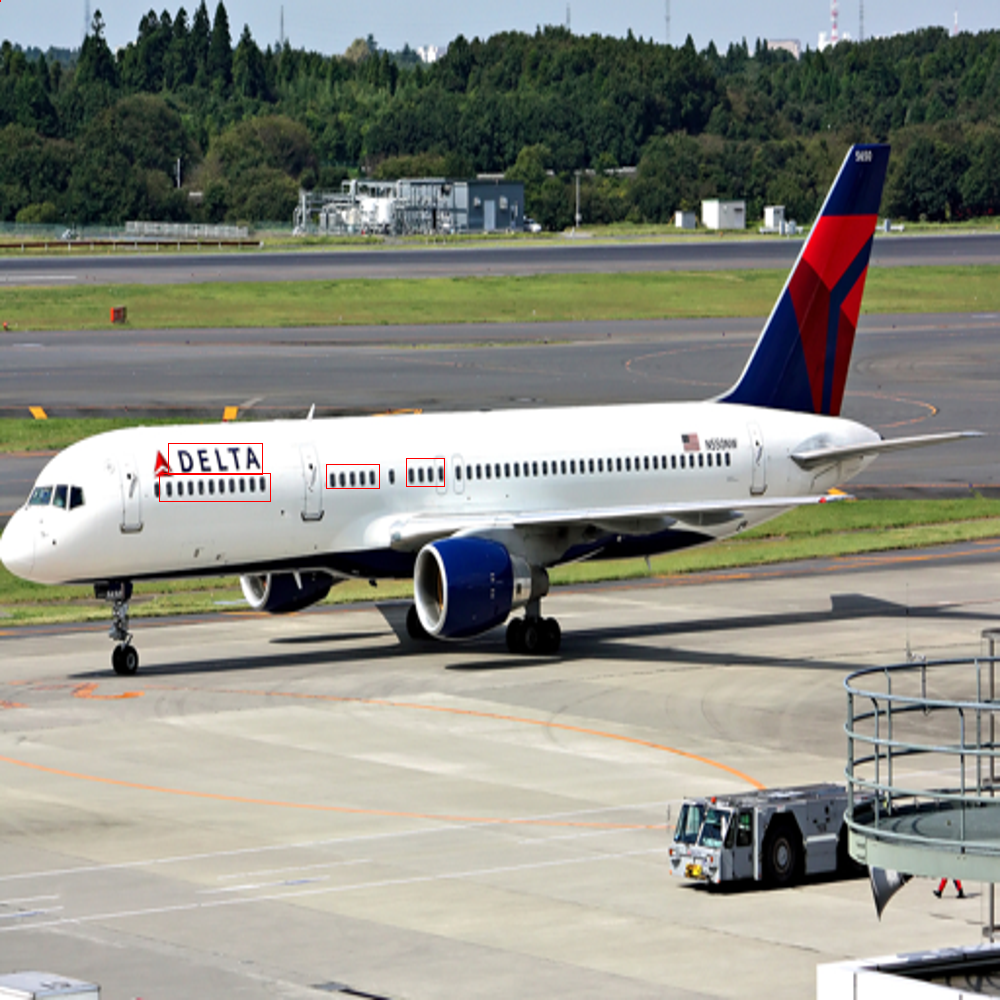

In [18]:
pil_image = ToPILImage()(encoding['pixel_values']).resize((1000, 1000))

## Foracoscopy clarity

actual_img = pil_image
draw_on_img = ImageDraw.Draw(actual_img)  

for box in encoding['bbox']:
  draw_on_img.rectangle(box.tolist()[:4], outline ="red")

actual_img

In [19]:
def pad_sequence(sequence, pad_value):
    max_len = 0
    for i in sequence:
        max_len = max(max_len, len(i))
    
    for i, _ in enumerate(sequence):
        pad_length = max_len - len(_)
        if pad_length != 0:
            pad_entry = torch.stack([pad_value for j in range(pad_length)])
            sequence[i] = torch.cat([sequence[i],pad_entry])

    return torch.stack(sequence)

def collate(data_bunch):
    '''
    A function for the dataloader to return a batch dict of given keys

    data_bunch: List of dictionary
    '''
    dict_data_bunch = {}

    for i in data_bunch:
        for (key, value) in i.items():
            if key not in dict_data_bunch:
                dict_data_bunch[key] = []
            dict_data_bunch[key].append(value)

    images = torch.stack(dict_data_bunch.pop('pixel_values'), axis = 0)
    for entry in dict_data_bunch:
        if entry == "bbox":
            dict_data_bunch[entry] = pad_sequence(dict_data_bunch[entry], torch.as_tensor([0, 0, 0, 0, 0, 0]))
        elif entry == 'labels':
            dict_data_bunch[entry] = pad_sequence(dict_data_bunch[entry], torch.as_tensor(-100))
        else:
            dict_data_bunch[entry] = pad_sequence(dict_data_bunch[entry], torch.as_tensor(0))
    return {"img": images, **dict_data_bunch}

In [20]:
first_sample = train_ds[22]
second_sample = train_ds[25]

In [21]:
batch_encoding = collate([first_sample, second_sample])

In [22]:
for key in batch_encoding:
    print(f"Key : {key}, has shape {batch_encoding[key].shape}")

Key : img, has shape torch.Size([2, 3, 384, 512])
Key : bbox, has shape torch.Size([2, 26, 6])
Key : input_ids, has shape torch.Size([2, 26])
Key : labels, has shape torch.Size([2, 13])
Key : attention_mask, has shape torch.Size([2, 26])


In [23]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 2):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, 
                      collate_fn = collate, shuffle = True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size,
                                  collate_fn = collate, shuffle = False)


In [24]:
dl = DataModule(train_ds, val_ds)

In [25]:
sample = next(iter(dl.train_dataloader()))

In [26]:
for key in sample:
    print(f"Key : {key}, has shape : {sample[key].shape}")

Key : img, has shape : torch.Size([2, 3, 384, 512])
Key : bbox, has shape : torch.Size([2, 49, 6])
Key : input_ids, has shape : torch.Size([2, 49])
Key : labels, has shape : torch.Size([2, 6])
Key : attention_mask, has shape : torch.Size([2, 49])
